<a href="https://colab.research.google.com/github/HernanDL/Noise-Cancellation-Using-GenAI/blob/main/Transfer_Learning_with_Wav2Vec2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Install and Import Libraries
#!pip install torchaudio transformers librosa

import torch
import torchaudio
import torchaudio.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor
import os
from google.colab import files


In [2]:
# Step 1: Upload Files from Local Computer
uploaded = files.upload()
# Retrieve the uploaded file's name
file_path = list(uploaded.keys())[0]

# To avoid memory fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

Saving Bn-ord-B3-mf-N-N.wav to Bn-ord-B3-mf-N-N.wav


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Loss: 0.0008098037797026336
Epoch [2/10], Loss: 0.0011677842121571302
Epoch [3/10], Loss: 0.0007966356934048235
Epoch [4/10], Loss: 0.0008154044044204056
Epoch [5/10], Loss: 0.0008177374256774783
Epoch [6/10], Loss: 0.0007953937747515738
Epoch [7/10], Loss: 0.0011766201350837946
Epoch [8/10], Loss: 0.0007990161539055407
Epoch [9/10], Loss: 0.0008235278655774891
Epoch [10/10], Loss: 0.000795079511590302
Original Input:


Predicted Anti-Noise:


Combined Result (Expected Silence):


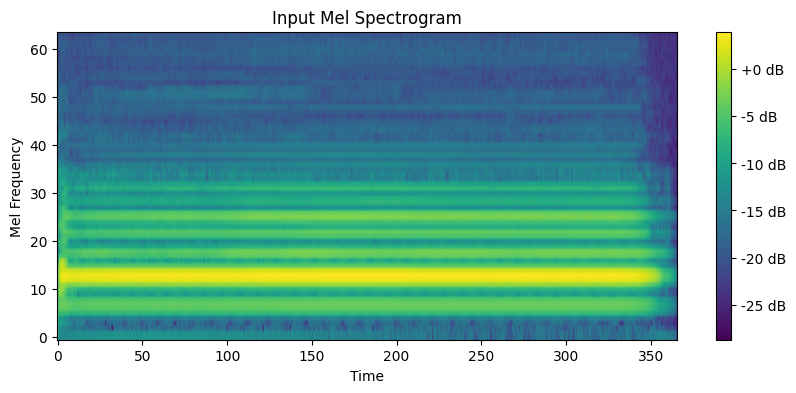

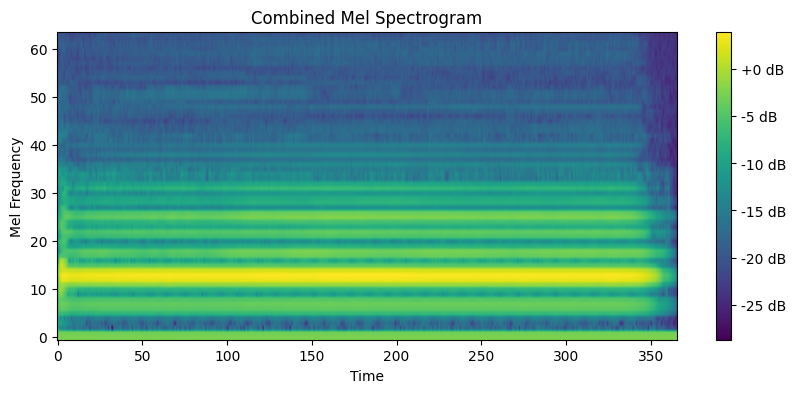

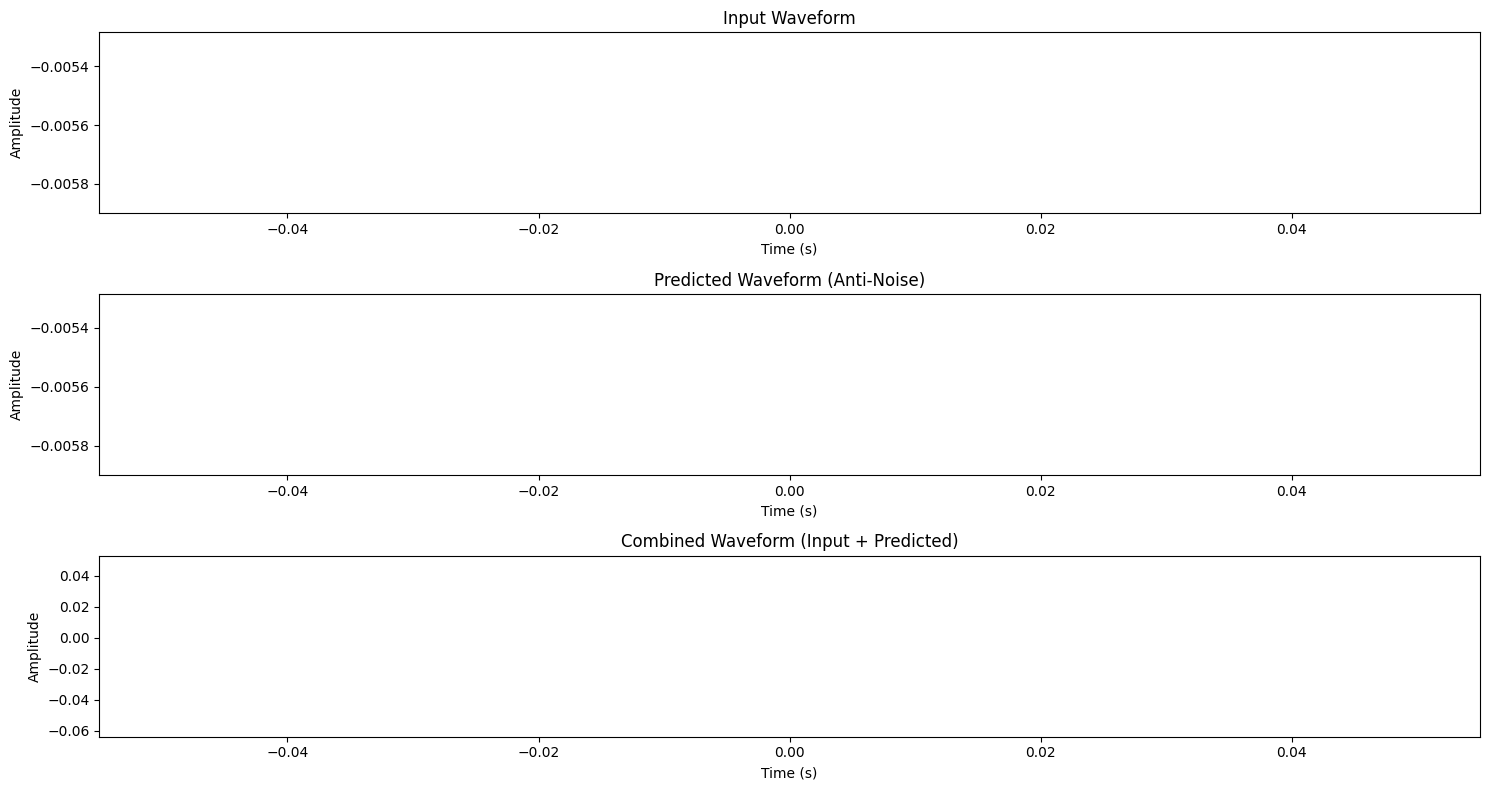

In [4]:
waveform, sr = torchaudio.load(file_path)

# Step 2: Resample to 16 kHz (Wav2Vec2 expected input)
waveform_resampled = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)(waveform)
sr = 16000  # Update sample rate

# Invert phase for the target
inverted_waveform = -waveform_resampled

# Step 3: Move to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
waveform_resampled = waveform_resampled.to(device)
inverted_waveform = inverted_waveform.to(device)

# Step 4: Load pre-trained Wav2Vec2 model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base-960h", num_labels=1)
model = model.to(device)

# Step 5: Define MSE Loss and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# Step 6: Training loop
model.train()
num_epochs = 10

for epoch in range(num_epochs):
    # Process input waveform for Wav2Vec2
    inputs = processor(waveform_resampled.squeeze().cpu().numpy(),
                       sampling_rate=sr,
                       return_tensors="pt",
                       padding=True).input_values

    inputs = inputs.to(device)

    # Forward pass
    optimizer.zero_grad()
    outputs = model(inputs).logits.squeeze()

    # Compute loss between model prediction and inverted phase waveform
    loss = loss_fn(outputs, inverted_waveform.squeeze())
    loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")

# Step 7: Evaluate the model and visualize results
model.eval()
with torch.no_grad():
    predicted_waveform = model(processor(waveform_resampled.squeeze().cpu().numpy(),
                                         sampling_rate=sr,
                                         return_tensors="pt",
                                         padding=True).input_values.to(device)).logits.squeeze()

# Step 8: Audio playback and visualization
# Move back to CPU for playback if using GPU
waveform_resampled = waveform_resampled.cpu()
predicted_waveform = predicted_waveform.cpu()
combined_waveform = waveform_resampled + predicted_waveform

# Ensure waveforms are 1D
predicted_waveform = predicted_waveform.view(-1)  # Flatten to 1D
combined_waveform = combined_waveform.view(-1)    # Flatten to 1D

# Play the input, predicted, and combined waveforms
print("Original Input:")
ipd.display(ipd.Audio(waveform_resampled.numpy(), rate=sr))

print("Predicted Anti-Noise:")
ipd.display(ipd.Audio(predicted_waveform.numpy(), rate=sr))

print("Combined Result (Expected Silence):")
ipd.display(ipd.Audio(combined_waveform.numpy(), rate=sr))

# Ensure predicted_waveform and combined_waveform are 2D before plotting
predicted_waveform = predicted_waveform.view(1, -1)  # Reshape to [1, num_samples]
combined_waveform = combined_waveform.view(1, -1)    # Reshape to [1, num_samples]

# Step 9: Plot Mel spectrograms
def plot_mel_spectrogram(waveform, sr, title):
    # Ensure the input tensor has a sufficient length
    if waveform.size(1) < 200:  # Check if the length is smaller than the required
        print(f"Warning: The waveform for '{title}' is too short to compute a Mel spectrogram.")
        return

    mel_spectrogram = transforms.MelSpectrogram(sample_rate=sr, n_mels=64)(waveform)

    # Squeeze the batch dimension
    mel_spectrogram = mel_spectrogram.squeeze(0)  # Remove the first dimension

    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spectrogram.log2().detach().numpy(), aspect='auto', origin='lower')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

# Plot spectrograms
plot_mel_spectrogram(waveform_resampled.view(1, -1), sr, "Input Mel Spectrogram")
plot_mel_spectrogram(predicted_waveform, sr, "Predicted Mel Spectrogram")
plot_mel_spectrogram(combined_waveform, sr, "Combined Mel Spectrogram")

# Function to Plot Waveforms
def plot_waveforms(input_waveform, predicted_waveform, combined_waveform, sr):
    time_axis = np.arange(input_waveform.size(1)) / sr
    plt.figure(figsize=(15, 8))

    plt.subplot(3, 1, 1)
    plt.plot(time_axis, input_waveform, color='blue')
    plt.title('Input Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(3, 1, 2)
    plt.plot(time_axis, predicted_waveform, color='red')
    plt.title('Predicted Waveform (Anti-Noise)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(3, 1, 3)
    plt.plot(time_axis, combined_waveform, color='green')
    plt.title('Combined Waveform (Input + Predicted)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

# Plot Waveforms
plot_waveforms(predicted_waveform, predicted_waveform, combined_waveform, sr)
